_Lambda School Data Science — Practicing & Understanding Predictive Modeling_

# Model Interpretation

### Links
- [Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)
  - [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance)
  - [Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
  - [Shapley Values](https://www.kaggle.com/dansbecker/shap-values)
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
  - [(Permutation) Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html)
  - [Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
  - [Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- Random Forest Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

### Libraries
- [eli5](https://github.com/TeamHG-Memex/eli5): `conda install -c conda-forge eli5` / `pip install eli5`
- [PDPbox](https://github.com/SauceCat/PDPbox): `pip install pdpbox`
- [shap](https://github.com/slundberg/shap): `conda install -c conda-forge shap` / `pip install shap`

### Library quirks to work around

1. Some of these libraries don't work with pipelines.

2. eli5 PermutationImportance + xgboost + pandas doesn't work, but [there's a work-around:](https://www.kaggle.com/dansbecker/permutation-importance#392299)

> Important note here for anyone trying to use eli5's PermutationImportance on XGBoost estimators, currently you need to train your models using ".values or .as_matrix()" with you input data (X and Y), otherwise PermutationImportance won't work, [source](https://github.com/TeamHG-Memex/eli5/issues/256).

3. PDPbox _only_ works with pandas.

***[Data science is often about putting square pegs in round holes!](https://www.youtube.com/watch?v=ry55--J4_VQ)***

### 3 types of model explanations today!

#### Global explanation: all features in relation to each other
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### Global explanation: individual feature(s) in relation to target
- Partial Dependence plots

#### Individual prediction explanation
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

### Lecture dataset: Lending Club

#### Can you predict if peer-to-peer loans are charged off or fully paid?

[Lending Club says,](https://www.lendingclub.com/) _"Our mission is to transform the banking system to make credit more affordable and investing more rewarding."_ You can view their [loan statistics and visualizations](https://www.lendingclub.com/info/demand-and-credit-profile.action).

[According to Wikipedia,](https://en.wikipedia.org/wiki/Lending_Club)

> Lending Club is the world's largest peer-to-peer lending platform. Lending Club enables borrowers to create unsecured personal loans between $1,000 and 40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The data is a stratified sample of 100,000 Lending Club peer-to-peer loans with a loan status of "Charged Off" or "Fully Paid", issued from 2007 through 2018.

The set of variables included here are the intersection of what's available both when investors download historical data and when investors browse loans for manual investing.

Data dictionary: https://resources.lendingclub.com/LCDataDictionary.xlsx

Target: `charged_off`

**This is a classification problem, so we'll choose a [scoring metric](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) for classification: ROC AUC.**

**For our evaluation protocol, we'll choose cross-validation with independent test set.**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500


url = 'https://drive.google.com/uc?export=download&id=1AafT_i1dmfaxqKiyFofVndleKozbQw3l'
df = pd.read_csv(url)

X = df.drop(columns='charged_off')
y = df['charged_off']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, test_size=0.20, stratify=y, random_state=42)


def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X


# Wrangle train and test in the same way
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [2]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.2s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa015fe97b8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa016517c18>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [3]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.7214766256277261


In [4]:
from sklearn.metrics import roc_auc_score
best = search.best_estimator_

X_test = encoder.transform(X_test)
y_pred_proba = best.predict_proba(X_test.values)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.7155068233276889


# 1a. Feature Importances
- Global explanation: all features in relation to each other
- Default, fastest, good for first estimates

[Here's some food for thought](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/) about feature importances:

>**When the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others.** But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

For more information, see [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html).

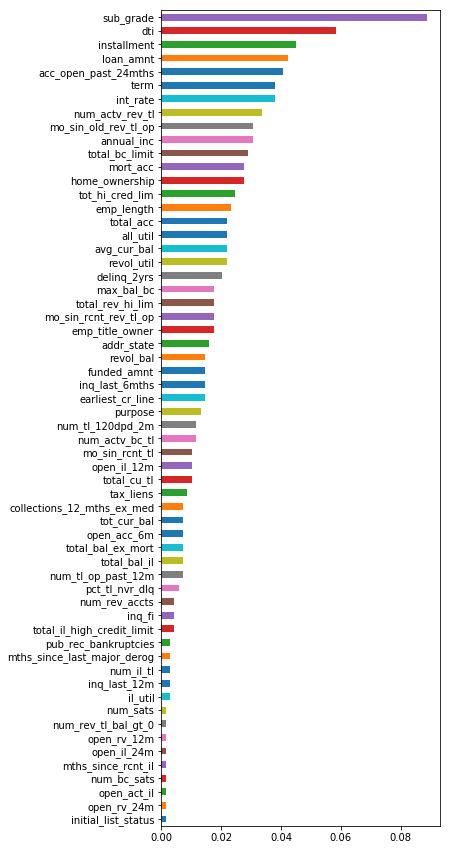

In [5]:
n = 60 #len(X_train.columns)
figsize = (5,15)

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]

plt.figure(figsize=figsize)
top_n.plot.barh();

# 1b. Drop-Column Importance
- Global explanation: all features in relation to each other
- The best in theory, but much too slow in practice

`sub_grade` is correlated with `int_rate`. If we drop `sub_grade`, the model uses other correlated features more, so the score remains similar.

In [6]:
from sklearn.model_selection import cross_val_score

X_train_no_subgrade = X_train.drop(columns='sub_grade')
new_model = XGBClassifier(max_depth=2, n_estimators=200, n_jobs=-1, random_state=42)

score_with = cross_val_score(new_model, X_train, y_train, cv=2, scoring='roc_auc').mean()
print('Cross-Validation ROC AUC with sub_grade:', score_with)

score_without = cross_val_score(new_model, X_train_no_subgrade, y_train, cv=2, scoring='roc_auc').mean()
print('Cross-Validation ROC AUC without sub_grade:', score_without)

print('Drop-Column Importance:', score_with - score_without)

Cross-Validation ROC AUC with sub_grade: 0.7210805152839438
Cross-Validation ROC AUC without sub_grade: 0.7192418242281939
Drop-Column Importance: 0.0018386910557498526


# 1c. Permutation Importance
- Global explanation: all features in relation to each other
- A good compromise!

Permutation Importance is a compromise between Feature Importance based on impurity reduction (which is the fastest) and Drop Column Importance (which is the "best.")

[The ELI5 library documentation explains,](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)

> Importance can be measured by looking at how much the score (accuracy, F1, R^2, etc. - any score we’re interested in) decreases when a feature is not available.
>
> To do that one can remove feature from the dataset, re-train the estimator and check the score. But it requires re-training an estimator for each feature, which can be computationally intensive. ...
>
>To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. It doesn’t work as-is, because estimators expect feature to be present. So instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.
>
>The method is most suitable for computing feature importances when a number of columns (features) is not huge; it can be resource-intensive otherwise.

### Do-It-Yourself way, for intuition

In [7]:
X_test['sub_grade'].head()

5055     2.3
86027    2.2
86874    4.4
59692    4.2
47200    2.4
Name: sub_grade, dtype: float64

In [8]:
X_test_permuted = X_test.copy()

X_test_permuted['sub_grade'] = np.random.permutation(X_test_permuted['sub_grade'])
X_test_permuted['sub_grade'].head()

5055     4.4
86027    2.3
86874    1.2
59692    4.5
47200    1.2
Name: sub_grade, dtype: float64

In [9]:
print('Test ROC AUC score with sub_grade: ', roc_auc_score(y_test, y_pred_proba))

y_pred_proba = best.predict_proba(X_test_permuted.values)[:,1]

print('Test ROC AUC score with sub_grade permuted: ', roc_auc_score(y_test, y_pred_proba))


Test ROC AUC score with sub_grade:  0.7155068233276889
Test ROC AUC score with sub_grade permuted:  0.6305210131503485


In [10]:
feature = 'initial_list_status'
X_test_permuted = X_test.copy()
X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature])

y_pred_proba = best.predict_proba(X_test.values)[:,1]

print(f'Test ROC AUC score with {feature}: ', roc_auc_score(y_test, y_pred_proba))

y_pred_proba = best.predict_proba(X_test_permuted.values)[:,1]

print(f'Test ROC AUC score with {feature} permuted: ', roc_auc_score(y_test, y_pred_proba))


Test ROC AUC score with initial_list_status:  0.7155068233276889
Test ROC AUC score with initial_list_status permuted:  0.7154893563300235


### With eli5 library

For more documentation on using this library, see:
- [eli5.sklearn.PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)
- [eli5.show_weights](https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights)

In [11]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='roc_auc', cv='prefit', 
                      n_iter=3, random_state=42)

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=229,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
           n_iter=3, random_state=42, refit=True, scoring='roc_auc')

In [12]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

### We can use importances for feature selection

For example, we can remove features with zero importance. The model trains faster and the score does not decrease.

In [13]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (80000, 98)


In [14]:
X_train

loan_amnt  funded_amnt  term  int_rate  installment  sub_grade  \
25539    24000.0      24000.0     1     11.99       533.75        2.5   
28968    25000.0      25000.0     2      7.89       782.15        1.5   
34666    34000.0      34000.0     2     16.99      1212.03        4.3   
20864     4200.0       4200.0     2     17.57       150.94        4.4   
75088    18000.0      18000.0     2     13.33       609.36        3.3   
69960     8000.0       8000.0     2     11.99       265.68        2.5   
2277      5200.0       5200.0     2     17.10       185.66        3.5   
89902    11000.0      11000.0     1     13.33       252.15        3.3   
76329     5000.0       5000.0     2     13.35       169.32        3.2   
68795    10000.0      10000.0     2     12.39       334.01        3.1   
19253    20000.0      20000.0     2      8.39       630.34        1.5   
25003    20000.0      20000.0     1     17.27       499.96        4.2   
84309    25000.0      25000.0     1     13.98       581.45        3.3   
76887    20300.0      20300.0     1     20.99       549.07        5.5   
28967     9000.0       9000.0     2      5.32       271.04        1.1   
22754     5000.0       5000.0     2      8.18       157.10        2.1   
47677     2500.0       2500.0     2     16.99        89.12        4.1   
18603     7000.0       7000.0     2     11.99       232.47        3.1   
64120    24700.0      24700.0     1     22.99       696.17        6.2   
98826    16000.0      16000.0     1     25.49       474.23        5.4   
63588    21000.0      21000.0     2     10.78       685.33        2.4   
35528     6000.0       6000.0     2      8.99       190.78        2.1   
30530     3500.0       3500.0     2     17.27       125.26        4.2   
79049    21000.0      21000.0     2      6.62       644.78        1.2   
67538    13000.0      13000.0     1     17.57       327.09        4.2   
26194     9600.0       9600.0     2      7.89       300.35        1.5   
23200    15000.0      15000.0     1     14.65       354.10        3.5   
16267    35000.0      35000.0     2      8.18      1099.69        2.1   
57971    10000.0      10000.0     2     12.99       336.90        3.1   
38352     5000.0       5000.0     2      8.24       157.24        2.1   
75442     6000.0       6000.0     2     12.62       201.07        3.1   
40534     5000.0       5000.0     2     15.61       174.83        4.1   
36520    18000.0      18000.0     2      5.32       542.07        1.1   
91639     8000.0       8000.0     2     13.11       269.98        2.4   
39801    20000.0      20000.0     1     13.11       456.19        2.4   
32993    20000.0      20000.0     2     10.99       654.68        2.4   
78873    16000.0      16000.0     1     15.99       389.01        3.5   
30911     5000.0       5000.0     2     12.49       167.25        2.5   
456      20000.0      20000.0     2      6.08       609.17        1.2   
74306     2500.0       2500.0     2     15.99        87.89        3.5   
70336     3000.0       3000.0     2     13.49       101.80        3.2   
83462    11775.0      11775.0     2     23.43       458.46        6.1   
56183     3225.0       3225.0     2     14.16       110.48        3.2   
23559     1725.0       1725.0     2     11.44        56.84        2.4   
35563     6000.0       6000.0     2      7.49       186.61        1.4   
30491     3000.0       3000.0     2     14.64       103.47        3.3   
97771    17000.0      17000.0     2      8.49       536.57        2.1   
40074    15000.0      15000.0     2      9.99       483.94        2.3   
51189     5000.0       5000.0     2     11.49       164.86        2.5   
25560    19125.0      19125.0     2     11.14       627.40        2.2   
11940    24000.0      24000.0     2     11.99       797.03        3.1   
28152     9600.0       9600.0     2     10.91       313.89        2.4   
43166     6000.0       6000.0     2     14.09       205.33        2.5   
21805     9000.0       9000.0     2     16.24       317.49       

In [15]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features: ', X_train.shape)

Shape after removing features:  (80000, 56)


In [16]:
# Refit the model after we remove features with zero importance

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.1s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa01b495438>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa01b495550>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [17]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.7212940497216871


In [18]:
best = search.best_estimator_
X_test = X_test[features]
y_pred_proba = best.predict_proba(X_test)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.7159255852058536


# 2. Partial Dependence Plots

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdpbox.pdp.pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdpbox.pdp.pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)

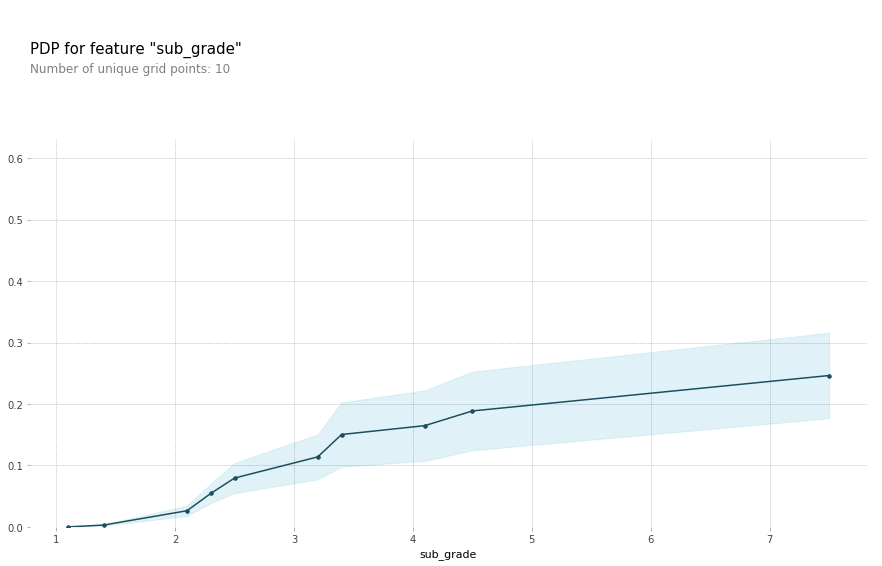

In [19]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'sub_grade'

isolated = pdp_isolate(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

In [20]:
isolated

### Explaining Partial Dependence Plots

From [PDPbox documentation](https://pdpbox.readthedocs.io/en/latest/):


>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

[Animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/)

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)

### Partial Dependence Plots with 2 features, to see interactions

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdpbox.pdp.pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdpbox.pdp.pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20:
- With the `pdp_interact_plot` function, `plot_type='contour` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40

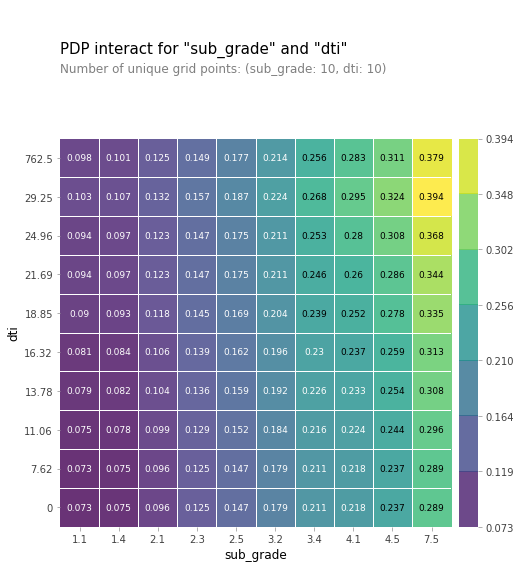

In [21]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['sub_grade', 'dti']

interaction = pdp_interact(
    model=best, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

# 3. Shapley Values to explain individual predictions

[Dan Becker explains,](https://www.kaggle.com/dansbecker/shap-values)

>You've seen (and used) techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?

>SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 

>There is some complexity to the technique ... We won't go into that detail here, since it isn't critical for using the technique. [This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

In [22]:
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)
confidence = np.abs(y_pred_proba - threshold)
preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 
                      'y_pred_proba': y_pred_proba, 
                      'confidence': confidence})

preds.head(50)

y_test  y_pred  y_pred_proba  confidence
5055        0       0      0.134517    0.365483
86027       1       0      0.108927    0.391073
86874       0       0      0.418926    0.081074
59692       0       0      0.259291    0.240709
47200       0       0      0.159552    0.340448
23370       0       0      0.188036    0.311964
96894       1       0      0.237891    0.262109
4937        0       0      0.091704    0.408296
8753        0       0      0.180970    0.319030
83293       0       0      0.407909    0.092091
67317       0       0      0.190320    0.309680
64023       0       0      0.153048    0.346952
82032       0       0      0.263749    0.236251
48341       0       0      0.362472    0.137528
80828       0       0      0.125313    0.374687
21413       0       0      0.254905    0.245095
30448       1       0      0.167611    0.332389
85755       0       0      0.067171    0.432829
81198       1       0      0.456821    0.043179
86373       0       0      0.102513    0.397487
45821       0       0      0.172413    0.327587
92222       0       0      0.079388    0.420612
27376       0       0      0.186469    0.313531
96943       0       0      0.207846    0.292154
8604        0       0      0.278501    0.221499
9224        0       0      0.288592    0.211408
61310       0       0      0.259215    0.240785
35012       1       0      0.218234    0.281766
60415       1       1      0.503153    0.003153
50075       1       0      0.099674    0.400326
96259       0       0      0.194387    0.305613
78150       1       0      0.300457    0.199543
69304       0       0      0.318522    0.181478
77863       1       0      0.362230    0.137770
3378        1       0      0.384594    0.115406
48976       0       0      0.157661    0.342339
58279       0       0      0.046153    0.453847
44828       0       0      0.074128    0.425872
18766       0       0      0.114441    0.385559
31365       0       0      0.097011    0.402989
91777       1       1      0.531179    0.031179
1613        0       0      0.374995    0.125005
35949       0       0      0.084527    0.415473
48375       0       0      0.187177    0.312823
19263       1       0      0.498494    0.001506
11701       0       0      0.231294    0.268706
42802       0       0      0.148728    0.351272
34198       0       0      0.294552    0.205448
80542       1       0      0.216769    0.283231
57304       0       0      0.245872    0.254128

### True positive

In [23]:
tp = preds[(y_pred==1) & (y_test==1)]
tp.sample(n=1)

y_test  y_pred  y_pred_proba  confidence
46634       1       1      0.569508    0.069508

In [24]:
data_for_prediction = X_test[X_test.index==91777]
data_for_prediction

loan_amnt  funded_amnt  term  int_rate  installment  sub_grade  \
91777    27575.0      27575.0     1     22.99        777.2        6.1   

       emp_length  home_ownership  annual_inc  purpose  addr_state    dti  \
91777       False               1     60000.0        1          19  36.34   

       delinq_2yrs  earliest_cr_line  inq_last_6mths  revol_bal  revol_util  \
91777          0.0              6374             0.0    23124.0        41.0   

       total_acc  initial_list_status  collections_12_mths_ex_med  \
91777       36.0                    1                         0.0   

       mths_since_last_major_derog  tot_cur_bal  open_acc_6m  open_act_il  \
91777                         True     157602.0     1.037912     2.834071   

       open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  \
91777     0.778971      1.73196                True  35978.789966     True   

       open_rv_12m  open_rv_24m   max_bal_bc   all_util  total_rev_hi_lim  \
91777     1.408442     2.991407  5441.304562  58.177199           56100.0   

         inq_fi  total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  \
91777  1.097055     1.587009      2.329079                  12.0       7164.0   

       mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  \
91777               False                 157.0                    1.0   

       mort_acc  num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_il_tl  \
91777       1.0             4.0              8.0          6.0        8.0   

       num_sats  num_tl_120dpd_2m  num_tl_op_past_12m  tax_liens  \
91777      22.0             False                 3.0        0.0   

       tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  \
91777         221755.0            50262.0         26500.0   

       total_il_high_credit_limit  emp_title_owner  
91777                     53455.0            False

In [29]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### True negative

In [26]:
tn = preds[(y_pred==0) & (y_test==0)]
tn.sample(n=1)

y_test  y_pred  y_pred_proba  confidence
12820       0       0       0.11758     0.38242

In [30]:
data_for_prediction = X_test[X_test.index==12999]
data_for_prediction

loan_amnt  funded_amnt  term  int_rate  installment  sub_grade  \
12999    10000.0      10000.0     1     11.44       219.63        2.4   

       emp_length  home_ownership  annual_inc  purpose  addr_state    dti  \
12999        True               1     40300.0        7           6  20.37   

       delinq_2yrs  earliest_cr_line  inq_last_6mths  revol_bal  revol_util  \
12999          0.0             16266             0.0     5226.0        28.4   

       total_acc  initial_list_status  collections_12_mths_ex_med  \
12999       23.0                    1                         0.0   

       mths_since_last_major_derog  tot_cur_bal  open_acc_6m  open_act_il  \
12999                         True     126847.0     1.037912     2.834071   

       open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  \
12999     0.778971      1.73196                True  35978.789966     True   

       open_rv_12m  open_rv_24m   max_bal_bc   all_util  total_rev_hi_lim  \
12999     1.408442     2.991407  5441.304562  58.177199           18400.0   

         inq_fi  total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  \
12999  1.097055     1.587009      2.329079                   6.0      14094.0   

       mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  \
12999               False                 480.0                   11.0   

       mort_acc  num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_il_tl  \
12999       5.0             2.0              3.0          6.0        5.0   

       num_sats  num_tl_120dpd_2m  num_tl_op_past_12m  tax_liens  \
12999       9.0             False                 1.0        0.0   

       tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  \
12999         147298.0            34104.0         14900.0   

       total_il_high_credit_limit  emp_title_owner  
12999                     33704.0            False

In [31]:
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [36]:
shap_values

# , X_test.columns
# pd.Series([shap_values], X_test.columns)

array([[-3.35279852e-03, -2.29539927e-02,  2.46678978e-01,
         7.99700022e-02, -1.68919154e-02, -2.98504859e-01,
         2.96963811e-01, -7.64941871e-02,  8.36236030e-02,
         2.98099499e-02,  3.12288199e-03,  2.41765697e-02,
        -1.11921104e-02, -3.97723354e-03, -2.68970300e-02,
         1.18703663e-03, -1.70278139e-02, -2.72644730e-03,
         0.00000000e+00, -2.32257484e-03, -3.28395888e-03,
         9.06323781e-04, -3.52324656e-04, -1.70613034e-03,
        -1.31918462e-02, -8.33127342e-06, -3.13422456e-03,
        -3.57859046e-03, -7.46089849e-04, -3.04253364e-04,
        -2.95323995e-03,  7.00561889e-03, -9.55538731e-03,
        -4.34033945e-03, -1.09413294e-02, -1.12743415e-02,
        -3.95409064e-04,  5.46593703e-02, -6.19840482e-03,
        -6.24878521e-05,  5.57273775e-02,  1.37313372e-02,
        -1.55239880e-01, -3.93989198e-02, -8.12430903e-02,
         0.00000000e+00,  1.48606487e-03,  1.16122852e-03,
        -3.61263030e-03, -1.22203780e-02, -2.96787522e-0

### False positive

In [37]:
tn = preds[(y_pred==1) & (y_test==0)]
tn.sample(n=1)

y_test  y_pred  y_pred_proba  confidence
52096       0       1      0.553135    0.053135

In [40]:
data_for_prediction = X_test[X_test.index==74681]
data_for_prediction

loan_amnt  funded_amnt  term  int_rate  installment  sub_grade  \
74681    21600.0      21600.0     1     25.29       637.67        5.5   

       emp_length  home_ownership  annual_inc  purpose  addr_state    dti  \
74681       False               1     54000.0        1           8  34.58   

       delinq_2yrs  earliest_cr_line  inq_last_6mths  revol_bal  revol_util  \
74681          0.0              4670             0.0     6789.0        43.0   

       total_acc  initial_list_status  collections_12_mths_ex_med  \
74681       34.0                    1                         0.0   

       mths_since_last_major_derog  tot_cur_bal  open_acc_6m  open_act_il  \
74681                         True      70309.0          0.0          3.0   

       open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  \
74681          0.0          1.0               False       63520.0    False   

       open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  \
74681          1.0          2.0      3498.0      58.0           15800.0   

       inq_fi  total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  \
74681     0.0          0.0           0.0                   3.0       7812.0   

       mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  \
74681               False                 106.0                   10.0   

       mort_acc  num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_il_tl  \
74681       0.0             4.0              5.0          4.0       26.0   

       num_sats  num_tl_120dpd_2m  num_tl_op_past_12m  tax_liens  \
74681       9.0             False                 1.0        0.0   

       tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  \
74681         101905.0            70309.0         13000.0   

       total_il_high_credit_limit  emp_title_owner  
74681                     86105.0            False

In [41]:
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### False negative

In [51]:
tn = preds[(y_pred==0) & (y_test==1)]
tn.sample(n=1)

y_test  y_pred  y_pred_proba  confidence
45693       1       0      0.176079    0.323921

In [53]:
data_for_prediction = X_test[X_test.index==10]
data_for_prediction

loan_amnt  funded_amnt  term  int_rate  installment  sub_grade  \
10    25200.0      25200.0     2     17.27       901.84        3.5   

    emp_length  home_ownership  annual_inc  purpose  addr_state    dti  \
10       False               1    111000.0        1          28  17.75   

    delinq_2yrs  earliest_cr_line  inq_last_6mths  revol_bal  revol_util  \
10          0.0              7014             6.0    22367.0        89.5   

    total_acc  initial_list_status  collections_12_mths_ex_med  \
10       32.0                    2                         0.0   

    mths_since_last_major_derog  tot_cur_bal  open_acc_6m  open_act_il  \
10                        False     301344.0     1.037912     2.834071   

    open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  \
10     0.778971      1.73196                True  35978.789966     True   

    open_rv_12m  open_rv_24m   max_bal_bc   all_util  total_rev_hi_lim  \
10     1.408442     2.991407  5441.304562  58.177199           25000.0   

      inq_fi  total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  \
10  1.097055     1.587009      2.329079                   2.0      23180.0   

    mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mort_acc  \
10               False                 158.0                   27.0       4.0   

    num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_il_tl  num_sats  \
10             6.0             10.0          6.0       10.0      13.0   

    num_tl_120dpd_2m  num_tl_op_past_12m  tax_liens  tot_hi_cred_lim  \
10             False                 1.0        0.0         321219.0   

    total_bal_ex_mort  total_bc_limit  total_il_high_credit_limit  \
10            81383.0         14700.0                     66514.0   

    emp_title_owner  
10            False

In [54]:
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

# ASSIGNMENT

In a clean notebook, using the **Seattle Bicycle Weather** dataset, make these visualizations:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values